In [ ]:
# do not include in script
from google.colab import drive
drive.mount('/content/drive')
apple_data_path = '/content/drive/MyDrive/Colab Notebooks'

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import cv2
from matplotlib import pyplot as plt
from sklearn.linear_model import RANSACRegressor
import matplotlib.colors as mcolors
import seaborn as sns
import math
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
# FOR TWO-WAY ANOVA
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm

In [ ]:
!pip install session_info==1.0.0
import session_info
session_info.show()

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 3.3 MB/s eta 0:00:00
  Created wheel for session_info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=f9c853ff0e46a09bcbbce883dcb66c831c0baf0a4c26d7fdf5cb97200ba2b92e
  Stored in directory: /root/.cache/pip/wheels/4e/56/35/a748fc57279a4b84d0b332879445fed1ad8478e7257986b015
Successfully built session_info


In [ ]:
script_path = '/content/drive/MyDrive/Colab Notebooks/utils_apple.py'
apple_data_path = '/content/drive/MyDrive/Colab Notebooks'

import importlib.util # IMPORTING CUSTOM MODULES ON COLAB IS WEIRD
spec = importlib.util.spec_from_file_location("utils_apple", script_path)
utils_apple = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utils_apple)

In [ ]:
badge_annotation = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/subset_annotation_2021_2022.xlsx')
output_path = os.path.join(apple_data_path,'total_pca')
used_cultivars = list(badge_annotation['Cultivar_name'].unique())
used_badges = list(badge_annotation['badge'].unique())
# add path of height-width + ratio data

if not os.path.exists(output_path):
    os.makedirs(output_path)

In [ ]:
relevant_locations = ['/content/drive/MyDrive/Colab Notebooks/2021/waedenswil',
                      '/content/drive/MyDrive/Colab Notebooks/2021/grabs',
                      '/content/drive/MyDrive/Colab Notebooks/2022/waedenswil',
                      '/content/drive/MyDrive/Colab Notebooks/2022/grabs']


In [ ]:
def prepare_color_height_width_df(path_color, path_traits):
  color_df = pd.read_csv(path_color, sep = '\t')
  trait_df = pd.read_csv(path_traits, sep = ',')
  return pd.merge(color_df, trait_df, on = ['badge', 'appleNR'], how = 'inner').drop(columns=['S_cam1','S_cam2','S_cam3','S_cam4','S_cam5','S_mean','Unnamed: 0'])

In [ ]:
w2021 = prepare_color_height_width_df(os.path.join(relevant_locations[0],'allcolhist.txt'), os.path.join(apple_data_path, 'dims_filtered_w2021.csv'))
g2021 = prepare_color_height_width_df(os.path.join(relevant_locations[1],'allcolhist.txt'), os.path.join(apple_data_path, 'dims_filtered_g2021.csv'))
w2022 = prepare_color_height_width_df(os.path.join(relevant_locations[2],'allcolhist.txt'), os.path.join(apple_data_path, 'dims_filtered_w2022.csv'))


In [ ]:
# fix the grabs 2022 mistake... again
g2022_col= pd.read_csv(os.path.join(relevant_locations[3],'allcolhist.txt'), sep = '\t')
g2022_badges = list(g2022_col['badge'])
for i in range(len(g2022_badges)):
  g2022_badges[i] = g2022_badges[i][0:4]+'0'+g2022_badges[i][4:]
g2022_col['badge'] = g2022_badges
g2022_dims = pd.read_csv(os.path.join(apple_data_path, 'dims_filtered_g2022.csv'), sep = ',')
g2022 = pd.merge(g2022_col, g2022_dims, on = ['badge', 'appleNR'], how = 'inner').drop(columns=['S_cam1','S_cam2','S_cam3','S_cam4','S_cam5','S_mean','Unnamed: 0'])

In [ ]:
w2021['Location'] = 'w'
g2021['Location'] = 'g'
w2022['Location'] = 'w'
g2022['Location'] = 'g'
w2021['Year'] = '2021'
g2021['Year'] = '2021'
w2022['Year'] = '2022'
g2022['Year'] = '2022'
total_df = pd.concat([w2021, g2021, w2022, g2022], axis=0)

In [ ]:
total_df

,value,H_cam1,H_cam2,H_cam3,H_cam4,H_cam5,H_mean,appleNR,badge,date,...,PL-Code,Cultivar_name,tree_nr,row,Locality,collection,Block,HWratio,Location,Year
0,0.013889,0.000000,0.000027,0.000000,0.000008,0.000000,0.000007,1,11.93.0.100,20220920095943,...,14-001-2774,Odo006,28,5,wae,SACC,B,0.971791,w,2021
1,0.041667,0.000000,0.000724,0.018469,0.000173,0.000017,0.003877,1,11.93.0.100,20220920095943,...,14-001-2774,Odo006,28,5,wae,SACC,B,0.971791,w,2021
2,0.069444,0.000166,0.037131,0.267113,0.030939,0.004745,0.068019,1,11.93.0.100,20220920095943,...,14-001-2774,Odo006,28,5,wae,SACC,B,0.971791,w,2021
3,0.097222,0.004082,0.054641,0.418243,0.076664,0.030196,0.116765,1,11.93.0.100,20220920095943,...,14-001-2774,Odo006,28,5,wae,SACC,B,0.971791,w,2021
4,0.125000,0.015052,0.061241,0.237040,0.077692,0.049426,0.088090,1,11.93.0.100,20220920095943,...,14-001-2774,Odo006,28,5,wae,SACC,B,0.971791,w,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212539,0.875000,0.000000,0.000009,0.000000,0.000000,0.000000,0.000002,8,50.00.0.2369,20221010081343,...,14-001-2616,Kitquap,65,17,gra,SACC,C,0.932908,g,2022
212540,0.902778,0.000000,0.000009,0.000000,0.000000,0.000000,0.000002,8,50.00.0.2369,20221010081343,...,14-001-2616,Kitquap,65,17,gra,SACC,C,0.932908,g,2022
212541,0.930556,0.000000,0.000000,0.000035,0.000000,0.000000,0.000007,8,50.00.0.2369,20221010081343,...,14-001-2616,Kitquap,65,17,gra,SACC,C,0.932908,g,2022
212542,0.958333,0.000000,0.000009,0.000052,0.000000,0.000000,0.000012,8,50.00.0.2369,20221010081343,...,14-001-2616,Kitquap,65,17,gra,SACC,C,0.932908,g,2022


## Filtering, adding and sorting hues for the PCA

This step is the most time-consuming. Estimated runtime: ~10 minutes

In [ ]:
def hue_rearranger(df, n_unique_hues):
  for i in range(0, len(df), n_unique_hues):
    range_lower, range_upper = i, i + n_unique_hues
    curr_apple_extract = df.iloc[range_lower:range_upper]

    if (i / n_unique_hues % 100 == 0):

    # add 3 last hues to the 3 first ones
    for j in range(3):
      curr_apple_extract.iloc[j, curr_apple_extract.columns.get_indexer(['H_cam1', 'H_cam2', 'H_cam3', 'H_cam4', 'H_cam5'])] += curr_apple_extract.iloc[n_unique_hues - j - 1, curr_apple_extract.columns.get_indexer(['H_cam1', 'H_cam2', 'H_cam3', 'H_cam4', 'H_cam5'])]
    df.iloc[range_lower:range_upper] = curr_apple_extract

  # choose only the first third of hues
  df = df[df.value < 0.33]
  print('finished sorting and adding hues...')
  return df

In [ ]:
n_unique_hues = len(w2021.value.unique())
w2021_filt = hue_rearranger(w2021, n_unique_hues)
g2021_filt = hue_rearranger(g2021, n_unique_hues)
w2022_filt = hue_rearranger(w2022, n_unique_hues)
g2022_filt = hue_rearranger(g2022, n_unique_hues)

## Obtain pca vector: steps
1. extract the 5 cameras
2. obtain the mean hue of each camera
3. obtain a 12 * 5 dimension vector of sorted cameras by mean hue value
4. append the height, width and hw-ratio of the respective apple

In [ ]:
def format_hue_df_for_pca(df_hue_filt, hue_averages):

  unique_combinations = df_hue_filt[['appleNR', 'badge']].drop_duplicates().values.tolist()

  current_cameras = {}
  for combo in unique_combinations:
    # key = mix of badge number and apple
    key = combo[1] + '_' + str(combo[0])
    # obtain relevant data from the badge number and apple combination
    current_cameras[key] = df_hue_filt[(df_hue_filt['appleNR'] == combo[0]) & (df_hue_filt['badge'] == combo[1])][['Cultivar_name','badge','appleNR','value','H_cam1','H_cam2','H_cam3','H_cam4','H_cam5','height_mean_cm','width_mean_cm','HWratio']]

  # obtain camera hue means
  i = 0
  pca_df = pd.DataFrame()
  for key in current_cameras:
    i += 1
    cam_cols = ['H_cam1', 'H_cam2'  , 'H_cam3', 'H_cam4', 'H_cam5']
    cam_sums = [current_cameras[key][col].sum() for col in cam_cols]
    for col in cam_cols:
        current_cameras[key][col] = current_cameras[key][col] / cam_sums[cam_cols.index(col)]


    for col in cam_cols:
      cam_means = [sum(current_cameras[key]['value']*current_cameras[key][col]) for col in cam_cols]
      cam_data = list(zip(cam_means, cam_cols))

      # sort zipped list by camera means
      sorted_cam_data = sorted(cam_data, key=lambda item: item[0])

      # for combining the vector in the correct order, obtain sorted means' camera names
      sorted_cam_cols = [item[1] for item in sorted_cam_data]

      if hue_averages:
        # plot sorted camera hue frequency means (from red / low to green / high)
        pca_df[key] = sorted(cam_means) + [current_cameras[key][size_col].values[0] for size_col in ['height_mean_cm','width_mean_cm','HWratio']]
      else:
        # add list of sorted camera hue values (red => green) to overal dataset with index being
        pca_df[key] = [value for col in current_cameras[key][cam_cols] for value in current_cameras[key][col].values] + [current_cameras[key][size_col].values[0] for size_col in ['height_mean_cm','width_mean_cm','HWratio']]

    if i % 100 == 0:
      print(i / len(unique_combinations) * 100, '% done')
  return pca_df

In [ ]:

w2021_pca = format_hue_df_for_pca(w2021_filt, hue_averages = True)
g2021_pca = format_hue_df_for_pca(g2021_filt, hue_averages = True)
w2022_pca = format_hue_df_for_pca(w2022_filt, hue_averages = True)
g2022_pca = format_hue_df_for_pca(g2022_filt, hue_averages = True)

3.063725490196078 % done
6.127450980392156 % done
9.191176470588236 % done
12.254901960784313 % done
15.318627450980394 % done
18.38235294117647 % done
21.44607843137255 % done
24.509803921568626 % done
27.573529411764707 % done
30.637254901960787 % done
33.700980392156865 % done
36.76470588235294 % done
39.82843137254902 % done
42.8921568627451 % done
45.955882352941174 % done
49.01960784313725 % done
52.083333333333336 % done
55.14705882352941 % done
58.2107843137255 % done
61.274509803921575 % done
64.33823529411765 % done
67.40196078431373 % done
70.4656862745098 % done
73.52941176470588 % done
76.59313725490196 % done
79.65686274509804 % done
82.72058823529412 % done
85.7843137254902 % done
88.84803921568627 % done
91.91176470588235 % done
94.97549019607843 % done
98.0392156862745 % done
1.6914749661705006 % done
3.3829499323410013 % done
5.074424898511502 % done
6.7658998646820026 % done
8.457374830852503 % done
10.148849797023004 % done
11.840324763193506 % done
13.5317997293640

In [ ]:
w2021_pca_df = w2021_pca
g2021_pca_df = g2021_pca
w2022_pca_df = w2022_pca
g2022_pca_df = g2022_pca

In [ ]:
# results already available in folder
#w2021_pca_df.to_csv(os.path.join(output_path,'w2021_pca_df.csv'))
#g2021_pca_df.to_csv(os.path.join(output_path,'g2021_pca_df.csv'))
#w2022_pca_df.to_csv(os.path.join(output_path,'w2022_pca_df.csv'))
#g2022_pca_df.to_csv(os.path.join(output_path,'g2022_pca_df.csv'))

In [ ]:
w2021_pca_prepared = utils_apple.prepare_pca(w2021_pca_df.fillna(0), 3, overall_df = True)
g2021_pca_prepared = utils_apple.prepare_pca(g2021_pca_df.fillna(0), 3, overall_df = True)
w2022_pca_prepared = utils_apple.prepare_pca(w2022_pca_df.fillna(0), 3, overall_df = True)
g2022_pca_prepared = utils_apple.prepare_pca(g2022_pca_df.fillna(0), 3, overall_df = True)

Explained variance by each component: [0.5699531  0.23594347 0.13643458]
Total explained variance: 0.94233
Explained variance by each component: [0.56486499 0.26704184 0.100322  ]
Total explained variance: 0.93223
Explained variance by each component: [0.5751224  0.2342534  0.13633628]
Total explained variance: 0.94571
Explained variance by each component: [0.57141381 0.2341459  0.1352981 ]
Total explained variance: 0.94086


In [ ]:
# ONLY RUN ONCE
w2021_pca_df = w2021_pca_df.add_prefix('w2021_')
g2021_pca_df = g2021_pca_df.add_prefix('g2021_')
w2022_pca_df = w2022_pca_df.add_prefix('w2022_')
g2022_pca_df = g2022_pca_df.add_prefix('g2022_')

In [ ]:
wg2122_combined_pca_df = pd.concat([w2021_pca_df, g2021_pca_df,
                                    w2022_pca_df, g2022_pca_df], axis=1)
wg2122_combined_pca_df

,w2021_11.93.0.100_1,w2021_11.93.0.100_2,w2021_11.93.0.100_3,w2021_11.93.0.100_4,w2021_11.93.0.100_5,w2021_11.93.0.100_6,w2021_11.93.0.100_7,w2021_11.93.0.100_8,w2021_11.93.0.1001_1,w2021_11.93.0.1001_2,...,g2022_50.00.0.2367_7,g2022_50.00.0.2367_8,g2022_50.00.0.2369_1,g2022_50.00.0.2369_2,g2022_50.00.0.2369_3,g2022_50.00.0.2369_4,g2022_50.00.0.2369_5,g2022_50.00.0.2369_6,g2022_50.00.0.2369_7,g2022_50.00.0.2369_8
0,0.098672,0.195352,0.129995,0.121173,0.092354,0.115404,0.154665,0.107490,0.148431,0.081480,...,0.138595,0.122840,0.017123,0.028352,0.029559,0.059092,0.036911,0.025715,0.021861,0.047358
1,0.161502,0.196086,0.194027,0.143993,0.094330,0.159671,0.187646,0.165954,0.162423,0.101774,...,0.141461,0.137360,0.042681,0.042732,0.039945,0.075398,0.040366,0.034353,0.028890,0.070041
2,0.175761,0.206224,0.196278,0.157030,0.176114,0.189137,0.192353,0.166268,0.172300,0.118945,...,0.146688,0.140485,0.054281,0.048539,0.047480,0.118117,0.049408,0.036885,0.036854,0.088318
3,0.181810,0.207641,0.198410,0.193760,0.186274,0.190067,0.193487,0.199311,0.177451,0.132253,...,0.151368,0.141631,0.063250,0.079003,0.054232,0.138478,0.067344,0.061076,0.061859,0.107569
4,0.199023,0.207643,0.200906,0.206933,0.197083,0.190957,0.203155,0.202374,0.178631,0.133673,...,0.165930,0.142094,0.064670,0.093262,0.102776,0.139182,0.094096,0.148133,0.068956,0.130723
5,9.029400,6.802900,6.593600,7.362500,6.860900,7.527400,7.159700,8.497100,6.219100,6.516600,...,7.260100,7.859000,7.419000,6.904500,7.046400,7.098600,7.172200,6.265000,6.499400,6.209900
6,9.291500,7.979300,8.729000,9.541400,8.591100,9.036000,8.907500,9.255200,6.601400,7.316600,...,6.929300,6.972100,7.157100,6.691700,6.854000,6.934300,7.015100,6.302800,6.630700,6.656500
7,0.971791,0.852569,0.755367,0.771637,0.798606,0.833046,0.803783,0.918089,0.942088,0.890660,...,1.047739,1.127207,1.036593,1.031801,1.028071,1.023694,1.022395,0.994003,0.980198,0.932908


In [ ]:
wg2122_combined_pca_prepared = utils_apple.prepare_pca(wg2122_combined_pca_df.fillna(0), 3, overall_df = True)
wg2122_combined_pca_prepared

Explained variance by each component: [0.56909674 0.24693303 0.12230399]
Total explained variance: 0.93833


In [ ]:
avg_camera_hue_pca_cols = ['badge_appleNR','cam1','cam2','cam3','cam4','cam5','height_mean_cm','width_mean_cm','HWratio']

In [ ]:
w2021_pca_prepared[['badge', 'appleNR']] = w2021_pca_prepared['badge'].str.rsplit('_', expand=True)
w2021_pca_prepared['appleNR'] = pd.to_numeric(w2021_pca_prepared['appleNR'], errors='coerce')
w2021_pca_prepared = pd.merge(w2021_pca_prepared, w2021[['badge','appleNR','Cultivar_name','height_mean_cm','width_mean_cm','HWratio']], on=['badge','appleNR']).drop_duplicates()
w2021_pca_df = w2021_pca_df.T.reset_index()
w2021_pca_df.columns = avg_camera_hue_pca_cols

g2021_pca_prepared[['badge', 'appleNR']] = g2021_pca_prepared['badge'].str.rsplit('_', expand=True)
g2021_pca_prepared['appleNR'] = pd.to_numeric(g2021_pca_prepared['appleNR'], errors='coerce')
g2021_pca_prepared = pd.merge(g2021_pca_prepared, g2021[['badge','appleNR','Cultivar_name','height_mean_cm','width_mean_cm','HWratio']], on=['badge','appleNR']).drop_duplicates()
g2021_pca_df = g2021_pca_df.T.reset_index()
g2021_pca_df.columns = avg_camera_hue_pca_cols

w2022_pca_prepared[['badge', 'appleNR']] = w2022_pca_prepared['badge'].str.rsplit('_', expand=True)
w2022_pca_prepared['appleNR'] = pd.to_numeric(w2022_pca_prepared['appleNR'], errors='coerce')
w2022_pca_prepared = pd.merge(w2022_pca_prepared, w2022[['badge','appleNR','Cultivar_name','height_mean_cm','width_mean_cm','HWratio']], on=['badge','appleNR']).drop_duplicates()
w2022_pca_df = w2022_pca_df.T.reset_index()
w2022_pca_df.columns = avg_camera_hue_pca_cols


g2022_pca_prepared[['badge', 'appleNR']] = g2022_pca_prepared['badge'].str.rsplit('_', expand=True)
g2022_pca_prepared['appleNR'] = pd.to_numeric(g2022_pca_prepared['appleNR'], errors='coerce')
g2022_pca_prepared = pd.merge(g2022_pca_prepared, g2022[['badge','appleNR','Cultivar_name','height_mean_cm','width_mean_cm','HWratio']], on=['badge','appleNR']).drop_duplicates()
g2022_pca_df = g2022_pca_df.T.reset_index()
g2022_pca_df.columns = avg_camera_hue_pca_cols


In [ ]:
total_df

,value,H_cam1,H_cam2,H_cam3,H_cam4,H_cam5,H_mean,appleNR,badge,date,...,PL-Code,Cultivar_name,tree_nr,row,Locality,collection,Block,HWratio,Location,Year
0,0.013889,0.000000,0.000027,0.000000,0.000008,0.000000,0.000007,1,11.93.0.100,20220920095943,...,14-001-2774,Odo006,28,5,wae,SACC,B,0.971791,w,2021
1,0.041667,0.000000,0.000724,0.018469,0.000173,0.000017,0.003877,1,11.93.0.100,20220920095943,...,14-001-2774,Odo006,28,5,wae,SACC,B,0.971791,w,2021
2,0.069444,0.000166,0.037131,0.267113,0.030939,0.004745,0.068019,1,11.93.0.100,20220920095943,...,14-001-2774,Odo006,28,5,wae,SACC,B,0.971791,w,2021
3,0.097222,0.004082,0.054641,0.418243,0.076664,0.030196,0.116765,1,11.93.0.100,20220920095943,...,14-001-2774,Odo006,28,5,wae,SACC,B,0.971791,w,2021
4,0.125000,0.015052,0.061241,0.237040,0.077692,0.049426,0.088090,1,11.93.0.100,20220920095943,...,14-001-2774,Odo006,28,5,wae,SACC,B,0.971791,w,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212539,0.875000,0.000000,0.000009,0.000000,0.000000,0.000000,0.000002,8,50.00.0.2369,20221010081343,...,14-001-2616,Kitquap,65,17,gra,SACC,C,0.932908,g,2022
212540,0.902778,0.000000,0.000009,0.000000,0.000000,0.000000,0.000002,8,50.00.0.2369,20221010081343,...,14-001-2616,Kitquap,65,17,gra,SACC,C,0.932908,g,2022
212541,0.930556,0.000000,0.000000,0.000035,0.000000,0.000000,0.000007,8,50.00.0.2369,20221010081343,...,14-001-2616,Kitquap,65,17,gra,SACC,C,0.932908,g,2022
212542,0.958333,0.000000,0.000009,0.000052,0.000000,0.000000,0.000012,8,50.00.0.2369,20221010081343,...,14-001-2616,Kitquap,65,17,gra,SACC,C,0.932908,g,2022


In [ ]:
wg2122_combined_pca_df = wg2122_combined_pca_df.T.reset_index()
wg2122_combined_pca_df.columns = avg_camera_hue_pca_cols

wg2122_combined_pca_prepared = pd.merge(wg2122_combined_pca_prepared,
                                        wg2122_combined_pca_df, left_on = 'badge',
                                        right_on = 'badge_appleNR').drop_duplicates()

In [ ]:
wg2122_combined_pca_prepared

,PC1,PC2,PC3,badge,badge_appleNR,cam1,cam2,cam3,cam4,cam5,height_mean_cm,width_mean_cm,HWratio
0,2.184415,2.639568,-0.511037,w2021_11.93.0.100_1,w2021_11.93.0.100_1,0.098672,0.161502,0.175761,0.181810,0.199023,9.0294,9.2915,0.971791
1,4.110968,0.287400,-0.802480,w2021_11.93.0.100_2,w2021_11.93.0.100_2,0.195352,0.196086,0.206224,0.207641,0.207643,6.8029,7.9793,0.852569
2,3.294702,0.126827,-1.975471,w2021_11.93.0.100_3,w2021_11.93.0.100_3,0.129995,0.194027,0.196278,0.198410,0.200906,6.5936,8.7290,0.755367
3,2.376703,1.010416,-2.249033,w2021_11.93.0.100_4,w2021_11.93.0.100_4,0.121173,0.143993,0.157030,0.193760,0.206933,7.3625,9.5414,0.771637
4,1.737074,0.262666,-1.598272,w2021_11.93.0.100_5,w2021_11.93.0.100_5,0.092354,0.094330,0.176114,0.186274,0.197083,6.8609,8.5911,0.798606
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18394,-0.216644,0.258576,1.011384,g2022_50.00.0.2369_4,g2022_50.00.0.2369_4,0.059092,0.075398,0.118117,0.138478,0.139182,7.0986,6.9343,1.023694
18395,-2.369970,0.192246,0.955588,g2022_50.00.0.2369_5,g2022_50.00.0.2369_5,0.036911,0.040366,0.049408,0.067344,0.094096,7.1722,7.0151,1.022395
18396,-2.140593,-0.835769,1.053478,g2022_50.00.0.2369_6,g2022_50.00.0.2369_6,0.025715,0.034353,0.036885,0.061076,0.148133,6.2650,6.3028,0.994003
18397,-2.933693,-0.614593,0.791168,g2022_50.00.0.2369_7,g2022_50.00.0.2369_7,0.021861,0.028890,0.036854,0.061859,0.068956,6.4994,6.6307,0.980198


In [ ]:
wg2122_combined_pca_prepared[['df', 'badge','appleNR']] = wg2122_combined_pca_prepared['badge'].str.rsplit('_', expand=True)
wg2122_combined_pca_prepared['Location'] = wg2122_combined_pca_prepared['df'].str[:1]
wg2122_combined_pca_prepared['Year'] = wg2122_combined_pca_prepared['df'].str[1:5]
wg2122_combined_pca_prepared = wg2122_combined_pca_prepared.drop(columns=['df', 'badge_appleNR'])
wg2122_combined_pca_prepared['appleNR'] = pd.to_numeric(wg2122_combined_pca_prepared['appleNR'], errors='coerce')

wg2122_combined_pca_prepared = pd.merge(wg2122_combined_pca_prepared,
                                        total_df[['badge','Cultivar_name','Location','Year']], on = ['badge','Location','Year']).drop_duplicates()

In [ ]:
# show final combined dataset
wg2122_combined_pca_prepared

,PC1,PC2,PC3,badge,cam1,cam2,cam3,cam4,cam5,height_mean_cm,width_mean_cm,HWratio,appleNR,Location,Year,Cultivar_name
0,2.184415,2.639568,-0.511037,11.93.0.100,0.098672,0.161502,0.175761,0.181810,0.199023,9.0294,9.2915,0.971791,1,w,2021,Odo006
288,4.110968,0.287400,-0.802480,11.93.0.100,0.195352,0.196086,0.206224,0.207641,0.207643,6.8029,7.9793,0.852569,2,w,2021,Odo006
576,3.294702,0.126827,-1.975471,11.93.0.100,0.129995,0.194027,0.196278,0.198410,0.200906,6.5936,8.7290,0.755367,3,w,2021,Odo006
864,2.376703,1.010416,-2.249033,11.93.0.100,0.121173,0.143993,0.157030,0.193760,0.206933,7.3625,9.5414,0.771637,4,w,2021,Odo006
1152,1.737074,0.262666,-1.598272,11.93.0.100,0.092354,0.094330,0.176114,0.186274,0.197083,6.8609,8.5911,0.798606,5,w,2021,Odo006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5185260,-0.216644,0.258576,1.011384,50.00.0.2369,0.059092,0.075398,0.118117,0.138478,0.139182,7.0986,6.9343,1.023694,4,g,2022,Kitquap
5185548,-2.369970,0.192246,0.955588,50.00.0.2369,0.036911,0.040366,0.049408,0.067344,0.094096,7.1722,7.0151,1.022395,5,g,2022,Kitquap
5185836,-2.140593,-0.835769,1.053478,50.00.0.2369,0.025715,0.034353,0.036885,0.061076,0.148133,6.2650,6.3028,0.994003,6,g,2022,Kitquap
5186124,-2.933693,-0.614593,0.791168,50.00.0.2369,0.021861,0.028890,0.036854,0.061859,0.068956,6.4994,6.6307,0.980198,7,g,2022,Kitquap


In [ ]:
w2021_pca_prepared['badge_appleNR'] = w2021_pca_prepared['badge'] + '_' + w2021_pca_prepared['appleNR'].astype(str)
g2021_pca_prepared['badge_appleNR'] = g2021_pca_prepared['badge'] + '_' + g2021_pca_prepared['appleNR'].astype(str)
w2022_pca_prepared['badge_appleNR'] = w2022_pca_prepared['badge'] + '_' + w2022_pca_prepared['appleNR'].astype(str)
g2022_pca_prepared['badge_appleNR'] = g2022_pca_prepared['badge'] + '_' + g2022_pca_prepared['appleNR'].astype(str)
w2021_pca_prepared.dropna(inplace=True)
g2021_pca_prepared.dropna(inplace=True)
w2022_pca_prepared.dropna(inplace=True)
g2022_pca_prepared.dropna(inplace=True)

In [ ]:
w2021_pca_prepared = pd.merge(w2021_pca_prepared, w2021_pca_df, on='badge_appleNR', suffixes=('','_trash'))[[c for c in w2021_pca_prepared.columns if not c.endswith('_trash')]]
g2021_pca_prepared = pd.merge(g2021_pca_prepared, g2021_pca_df, on='badge_appleNR', suffixes=('','_trash'))[[c for c in g2021_pca_prepared.columns if not c.endswith('_trash')]]
w2022_pca_prepared = pd.merge(w2022_pca_prepared, w2022_pca_df, on='badge_appleNR', suffixes=('','_trash'))[[c for c in w2022_pca_prepared.columns if not c.endswith('_trash')]]
g2022_pca_prepared = pd.merge(g2022_pca_prepared, g2022_pca_df, on='badge_appleNR', suffixes=('','_trash'))[[c for c in g2022_pca_prepared.columns if not c.endswith('_trash')]]

In [ ]:
w2021_pca_cultivar_means = w2021_pca_prepared[['Cultivar_name', 'PC1', 'PC2', 'PC3']].groupby('Cultivar_name').mean()
w2021_pca_cultivar_means[['PC1_sd', 'PC2_sd', 'PC3_sd']]= w2021_pca_prepared[['Cultivar_name', 'PC1', 'PC2', 'PC3']].groupby('Cultivar_name').std()
w2021_pca_cultivar_means.to_csv(os.path.join(output_path,'w2021_pca_cultivar_means.csv'))

g2021_pca_cultivar_means = g2021_pca_prepared[['Cultivar_name', 'PC1', 'PC2', 'PC3']].groupby('Cultivar_name').mean()
g2021_pca_cultivar_means[['PC1_sd', 'PC2_sd', 'PC3_sd']]= g2021_pca_prepared[['Cultivar_name', 'PC1', 'PC2', 'PC3']].groupby('Cultivar_name').std()
w2021_pca_cultivar_means.to_csv(os.path.join(output_path,'g2021_pca_cultivar_means.csv'))

w2022_pca_cultivar_means = w2022_pca_prepared[['Cultivar_name', 'PC1', 'PC2', 'PC3']].groupby('Cultivar_name').mean()
w2022_pca_cultivar_means[['PC1_sd', 'PC2_sd', 'PC3_sd']]= w2022_pca_prepared[['Cultivar_name', 'PC1', 'PC2', 'PC3']].groupby('Cultivar_name').std()
w2022_pca_cultivar_means.to_csv(os.path.join(output_path,'w2022_pca_cultivar_means.csv'))

g2022_pca_cultivar_means = g2022_pca_prepared[['Cultivar_name', 'PC1', 'PC2', 'PC3']].groupby('Cultivar_name').mean()
g2022_pca_cultivar_means[['PC1_sd', 'PC2_sd', 'PC3_sd']]= g2022_pca_prepared[['Cultivar_name', 'PC1', 'PC2', 'PC3']].groupby('Cultivar_name').std()
g2022_pca_cultivar_means.to_csv(os.path.join(output_path,'g2022_pca_cultivar_means.csv'))


In [ ]:
# results already available in folder
#w2021_pca_prepared.to_csv(os.path.join(output_path,'w2021_cam_hue_avg_pca.csv'))
#g2021_pca_prepared.to_csv(os.path.join(output_path,'g2021_cam_hue_avg_pca.csv'))
#w2022_pca_prepared.to_csv(os.path.join(output_path,'w2022_cam_hue_avg_pca.csv'))
#g2022_pca_prepared.to_csv(os.path.join(output_path,'g2022_cam_hue_avg_pca.csv'))

In [ ]:
#pd.merge(w2021_pca_prepared)
w2021_pca_prepared

,PC1,PC2,PC3,badge,appleNR,Cultivar_name,height_mean_cm,width_mean_cm,HWratio,badge_appleNR


In [ ]:
#w2021_pca_allhues_prepared[['badge', 'appleNR']] = w2021_pca_allhues_prepared['badge'].str.rsplit('_', expand=True)
#w2021_pca_allhues_prepared['appleNR'] = pd.to_numeric(w2021_pca_allhues_prepared['appleNR'], errors='coerce')
#w2021_pca_allhues_prepared = pd.merge(w2021_pca_allhues_prepared, w2021[['badge','appleNR','Cultivar_name','height_mean_cm','width_mean_cm','HWratio']], on=['badge','appleNR']).drop_duplicates()

#g2021_pca_allhues_prepared[['badge', 'appleNR']] = g2021_pca_allhues_prepared['badge'].str.rsplit('_', expand=True)
#g2021_pca_allhues_prepared['appleNR'] = pd.to_numeric(g2021_pca_allhues_prepared['appleNR'], errors='coerce')
#g2021_pca_allhues_prepared = pd.merge(g2021_pca_allhues_prepared, g2021[['badge','appleNR','Cultivar_name','height_mean_cm','width_mean_cm','HWratio']], on=['badge','appleNR']).drop_duplicates()

#w2022_pca_allhues_prepared[['badge', 'appleNR']] = w2022_pca_allhues_prepared['badge'].str.rsplit('_', expand=True)
#w2022_pca_allhues_prepared['appleNR'] = pd.to_numeric(w2022_pca_allhues_prepared['appleNR'], errors='coerce')
#w2022_pca_allhues_prepared = pd.merge(w2022_pca_allhues_prepared, w2022[['badge','appleNR','Cultivar_name','height_mean_cm','width_mean_cm','HWratio']], on=['badge','appleNR']).drop_duplicates()

#g2022_pca_allhues_prepared[['badge', 'appleNR']] = g2022_pca_allhues_prepared['badge'].str.rsplit('_', expand=True)
#g2022_pca_allhues_prepared['appleNR'] = pd.to_numeric(g2022_pca_allhues_prepared['appleNR'], errors='coerce')
#g2022_pca_allhues_prepared = pd.merge(g2022_pca_allhues_prepared, g2022[['badge','appleNR','Cultivar_name','height_mean_cm','width_mean_cm','HWratio']], on=['badge','appleNR']).drop_duplicates()

PCA with all individual hues instead of hue averages - too computationally intensive and doesn't seem to provide a better result

In [ ]:
#w2021_pca_allhues_df = format_hue_df_for_pca(w2021_filt, hue_averages = False)
#g2021_pca_allhues_df = format_hue_df_for_pca(g2021_filt, hue_averages = False)
#w2022_pca_allhues_df = format_hue_df_for_pca(w2022_filt, hue_averages = False)
#g2022_pca_allhues_df = format_hue_df_for_pca(g2022_filt, hue_averages = False)

In [ ]:
#w2021_pca_allhues_prepared = utils_apple.prepare_pca(w2021_pca_allhues_df.fillna(0), 22, overall_df = True)
#g2021_pca_allhues_prepared = utils_apple.prepare_pca(g2021_pca_allhues_df.fillna(0), 22, overall_df = True)
#w2022_pca_allhues_prepared = utils_apple.prepare_pca(w2022_pca_allhues_df.fillna(0), 22, overall_df = True)
#g2022_pca_allhues_prepared = utils_apple.prepare_pca(g2022_pca_allhues_df.fillna(0), 22, overall_df = True)

In [ ]:
#w2021_pca_allhues_prepared['badge_appleNR'] = w2021_pca_allhues_prepared['badge'] + '_' + w2021_pca_allhues_prepared['appleNR'].astype(str)
#g2021_pca_allhues_prepared['badge_appleNR'] = g2021_pca_allhues_prepared['badge'] + '_' + g2021_pca_allhues_prepared['appleNR'].astype(str)
#w2022_pca_allhues_prepared['badge_appleNR'] = w2022_pca_allhues_prepared['badge'] + '_' + w2022_pca_allhues_prepared['appleNR'].astype(str)
#g2022_pca_allhues_prepared['badge_appleNR'] = g2022_pca_allhues_prepared['badge'] + '_' + g2022_pca_allhues_prepared['appleNR'].astype(str)
#w2021_pca_allhues_prepared.dropna(inplace=True)
#g2021_pca_allhues_prepared.dropna(inplace=True)
#w2022_pca_allhues_prepared.dropna(inplace=True)
#g2022_pca_allhues_prepared.dropna(inplace=True)

In [ ]:
#g2021_pca_allhues_prepared.iloc[:,[0,1,2]]

/content/drive/MyDrive/Colab Notebooks/utils_apple.py:380: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


ValueError: Axis limits cannot be NaN or Inf

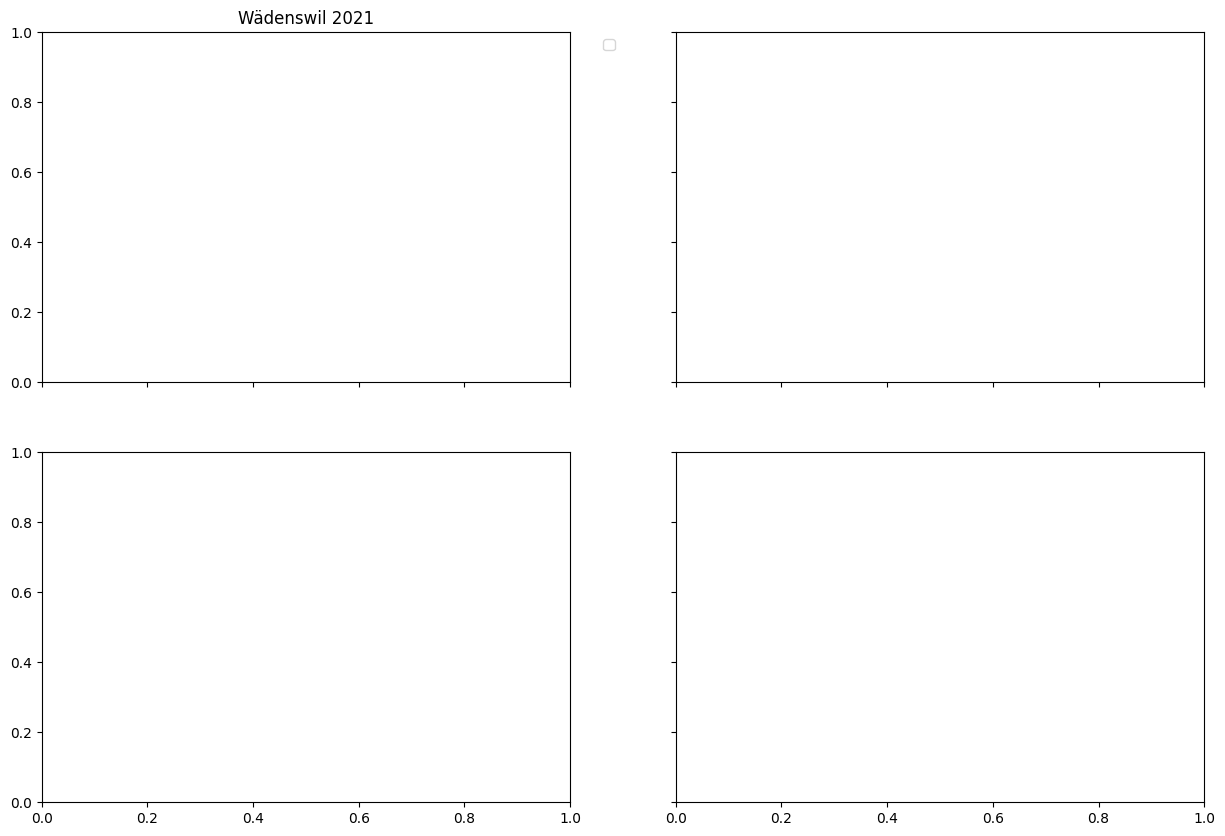

In [ ]:
utils_apple.plot_cultivar_size_consistency([w2021_pca_prepared.drop('PC1', axis=1), w2022_pca_prepared.drop('PC1', axis=1),
                                            g2021_pca_prepared.drop('PC1', axis=1), g2022_pca_prepared.drop('PC1', axis=1)],
                                          'PCA of all apple data based on per camera sorted hue averages, height and width\nin Wädenswil and Grabs in 2021 and 2022.',
                                           used_cultivars, os.path.join(output_path,'pca_average_hue_pc23'),
                                           include_guidelines = False)
utils_apple.plot_cultivar_size_consistency([w2021_pca_prepared.drop('PC2', axis=1), w2022_pca_prepared.drop('PC2', axis=1),
                                            g2021_pca_prepared.drop('PC2', axis=1), g2022_pca_prepared.drop('PC2', axis=1)],
                                          'PCA of all apple data based on per camera sorted hue averages, height and width\nin Wädenswil and Grabs in 2021 and 2022.',
                                           used_cultivars, os.path.join(output_path,'pca_average_hue_pc13'),
                                           include_guidelines = False)
utils_apple.plot_cultivar_size_consistency([w2021_pca_prepared, w2022_pca_prepared, g2021_pca_prepared, g2022_pca_prepared],
                                          'PCA of all apple data based on per camera sorted hue averages, height and width\nin Wädenswil and Grabs in 2021 and 2022.',
                                           used_cultivars, os.path.join(output_path,'pca_average_hue_pc12'),
                                           include_guidelines = False)

In [ ]:
# prompt: plot the dataset wg2122_combined_pca_prepared as scatter plot with alpha = 0.05, PC1 as x axis and PC3 as y axis

plt.figure(figsize=(10, 8))
plt.scatter(wg2122_combined_pca_prepared['PC1'], wg2122_combined_pca_prepared['PC3'], alpha=0.05)
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title('PCA of all apple data points ')
plt.show()


Check whether the PCA of all data is distributed similarly

In [ ]:
def plot_location_year_highlight(df, location, year):
    plt.figure(figsize=(10, 8))

    # semitransparent gray dots from all data as background
    plt.scatter(df['PC1'], df['PC3'], alpha=0.05, color='gray')

    # highlight specific year and locaiton
    subset = df[(df['Location'] == location) & (df['Year'] == year)]
    plt.scatter(subset['PC1'], subset['PC3'], alpha=0.2, color='red', label=f'{location} {year}')

    if location == "w":
      loc_name = "Wädenswil"
    elif location == "g":
      loc_name = "Grabs"
    else: loc_name = "Conthey"

    plt.xlabel('PC1')
    plt.ylabel('PC3')
    plt.title(f'Scatter Plot of PC1 vs PC3 (Highlighting {loc_name} {year})')
    plt.legend()
    plt.show()

plot_location_year_highlight(wg2122_combined_pca_prepared, 'w', '2021')
plot_location_year_highlight(wg2122_combined_pca_prepared, 'g', '2021')
plot_location_year_highlight(wg2122_combined_pca_prepared, 'w', '2022')
plot_location_year_highlight(wg2122_combined_pca_prepared, 'g', '2022')

In [ ]:
utils_apple.plot_cultivar_size_consistency([w2021_pca_allhues_prepared.drop('PC1', axis=1), w2022_pca_allhues_prepared.drop('PC1', axis=1),
                                            g2021_pca_allhues_prepared.drop('PC1', axis=1), g2022_pca_allhues_prepared.drop('PC1', axis=1)],
                                          'PCA of all apple data based on per camera sorted hues, height and width\nin Wädenswil and Grabs in 2021 and 2022.',
                                           used_cultivars, os.path.join(output_path,'pca_allhues_pc23'),
                                           include_guidelines = False)
utils_apple.plot_cultivar_size_consistency([w2021_pca_allhues_prepared.drop('PC2', axis=1), w2022_pca_allhues_prepared.drop('PC2', axis=1),
                                            g2021_pca_allhues_prepared.drop('PC2', axis=1), g2022_pca_allhues_prepared.drop('PC2', axis=1)],
                                          'PCA of all apple data based on per camera sorted hues, height and width\nin Wädenswil and Grabs in 2021 and 2022.',
                                           used_cultivars, os.path.join(output_path,'pca_allhues_pc13'),
                                           include_guidelines = False)
utils_apple.plot_cultivar_size_consistency([w2021_pca_allhues_prepared, w2022_pca_allhues_prepared,
                                            g2021_pca_allhues_prepared, g2022_pca_allhues_prepared],
                                          'PCA of all apple data based on per camera sorted hues, height and width\nin Wädenswil and Grabs in 2021 and 2022.',
                                           used_cultivars, os.path.join(output_path,'pca_allhues_pc12'),
                                           include_guidelines = False)

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(w2021_pca_prepared['PC3'], w2021_pca_prepared['PC2'], w2021_pca_prepared['PC1'],
           c=w2021_pca_prepared['height_mean_cm'], cmap = 'viridis')


ax.set_xlabel('Principal Component 1 (PC1)')
ax.set_ylabel('Principal Component 2 (PC2)')
ax.set_zlabel('Principal Component 3 (PC3)')

fig.colorbar(scatter, label='height')
ax.set_title('3D PCA Transformed Data Waedenswil 2021')
plt.savefig(os.path.join(output_path,'w2021_height_pca.png'))
plt.show()

## Correlation of PCs to input variables

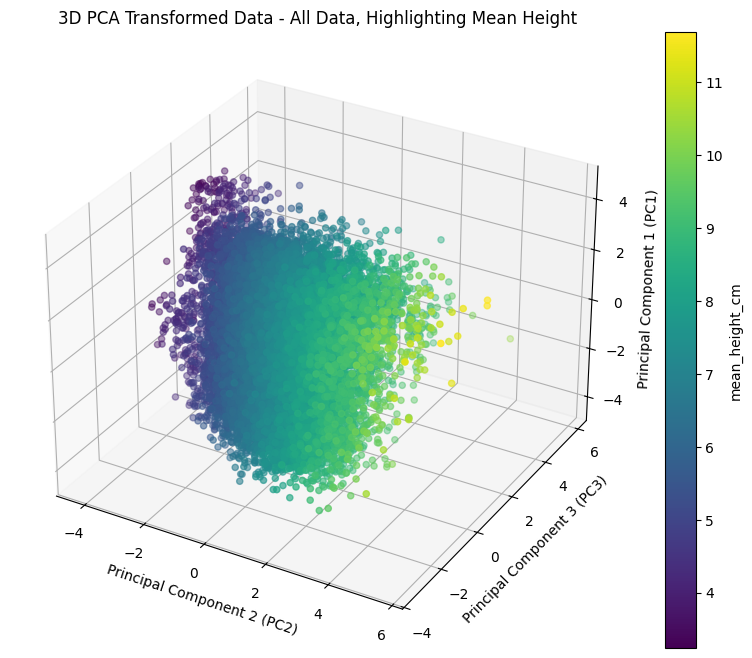

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(wg2122_combined_pca_prepared['PC2'],
                     wg2122_combined_pca_prepared['PC3'],
                     wg2122_combined_pca_prepared['PC1'],
                     c=wg2122_combined_pca_prepared['height_mean_cm'], cmap='viridis')

ax.set_xlabel('Principal Component 2 (PC2)')
ax.set_ylabel('Principal Component 3 (PC3)')
ax.set_zlabel('Principal Component 1 (PC1)')

fig.colorbar(scatter, label='mean_height_cm')
ax.set_title('3D PCA Transformed Data - All Data, Highlighting Mean Height')
plt.show()


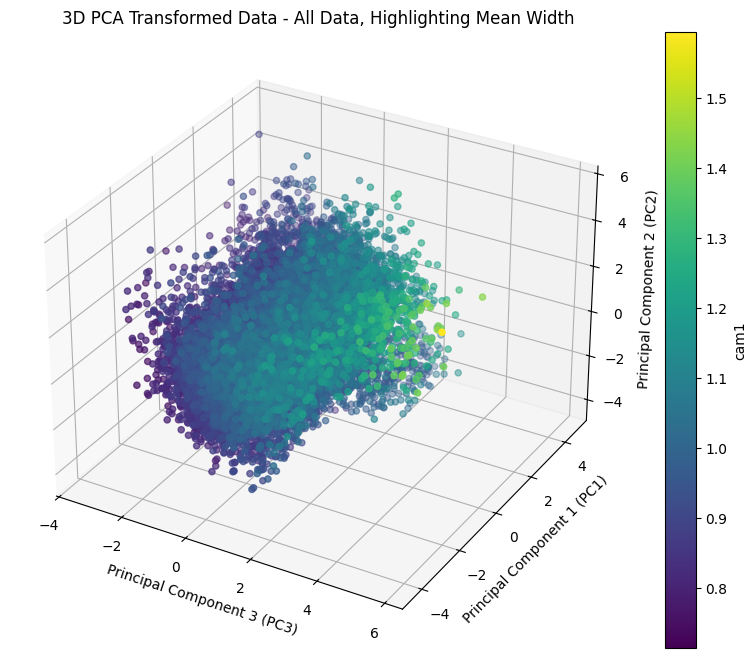

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(wg2122_combined_pca_prepared['PC3'],
                     wg2122_combined_pca_prepared['PC1'],
                     wg2122_combined_pca_prepared['PC2'],
                     c=wg2122_combined_pca_prepared['HWratio'], cmap='viridis')

ax.set_xlabel('Principal Component 3 (PC3)')
ax.set_ylabel('Principal Component 1 (PC1)')
ax.set_zlabel('Principal Component 2 (PC2)')

fig.colorbar(scatter, label='cam1')
ax.set_title('3D PCA Transformed Data - All Data, Highlighting Mean Width')
plt.show()


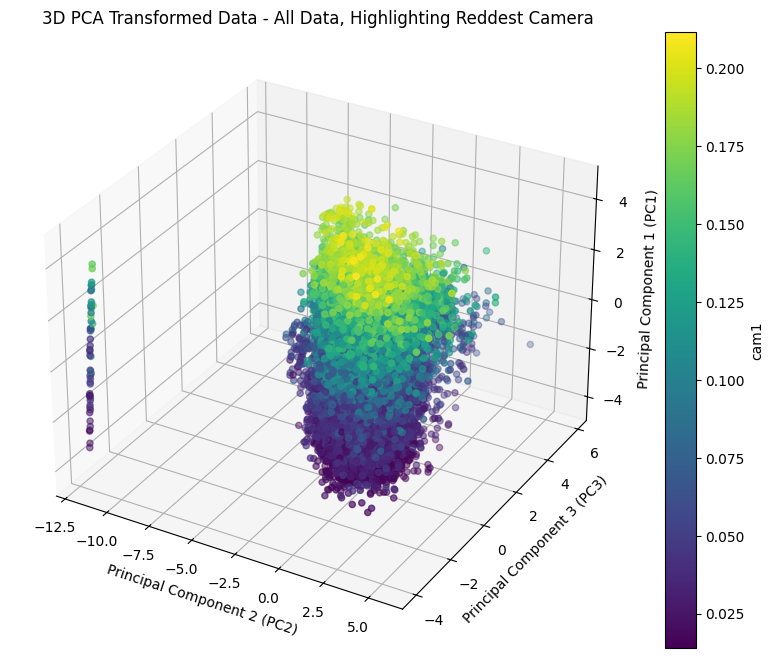

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(wg2122_combined_pca_prepared['PC2'],
                     wg2122_combined_pca_prepared['PC3'],
                     wg2122_combined_pca_prepared['PC1'],
                     c=wg2122_combined_pca_prepared['cam1'], cmap='viridis')

ax.set_xlabel('Principal Component 2 (PC2)')
ax.set_ylabel('Principal Component 3 (PC3)')
ax.set_zlabel('Principal Component 1 (PC1)')

fig.colorbar(scatter, label='cam1')
ax.set_title('3D PCA Transformed Data - All Data, Highlighting Reddest Camera')
plt.show()


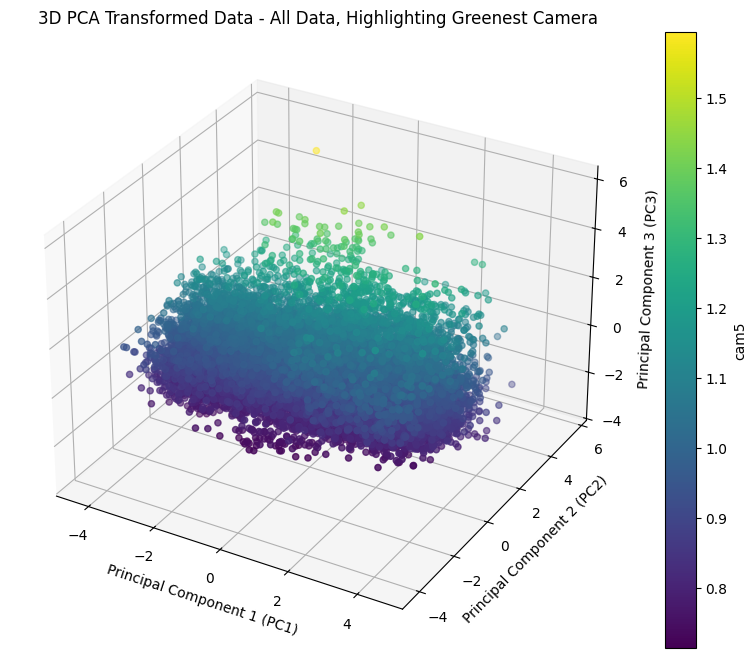

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(wg2122_combined_pca_prepared['PC1'],
                     wg2122_combined_pca_prepared['PC2'],
                     wg2122_combined_pca_prepared['PC3'],
                     c=wg2122_combined_pca_prepared['HWratio'], cmap='viridis')

ax.set_xlabel('Principal Component 1 (PC1)')
ax.set_ylabel('Principal Component 2 (PC2)')
ax.set_zlabel('Principal Component 3 (PC3)')

fig.colorbar(scatter, label='cam5')
ax.set_title('3D PCA Transformed Data - All Data, Highlighting Greenest Camera')
plt.show()


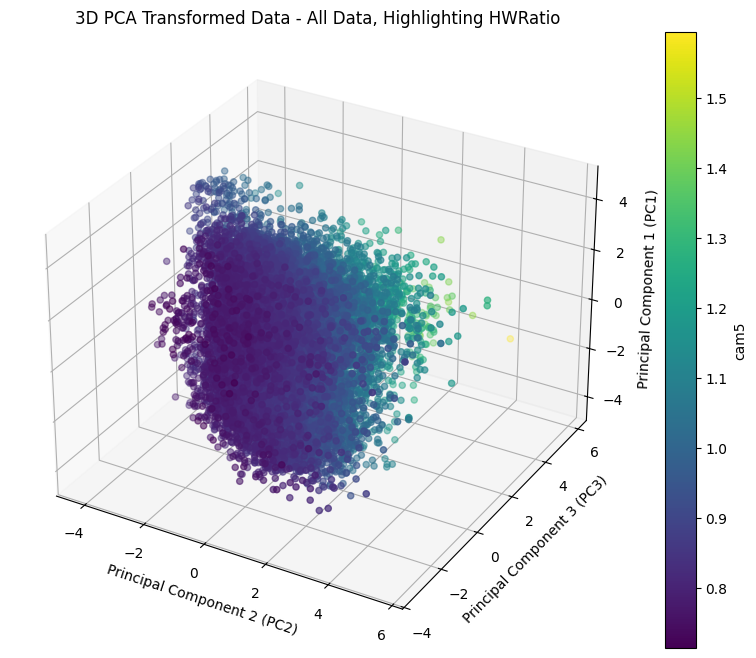

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(wg2122_combined_pca_prepared['PC2'],
                     wg2122_combined_pca_prepared['PC3'],
                     wg2122_combined_pca_prepared['PC1'],
                     c=wg2122_combined_pca_prepared['HWratio'], cmap='viridis')

ax.set_xlabel('Principal Component 2 (PC2)')
ax.set_ylabel('Principal Component 3 (PC3)')
ax.set_zlabel('Principal Component 1 (PC1)')

fig.colorbar(scatter, label='cam5')
ax.set_title('3D PCA Transformed Data - All Data, Highlighting HWRatio')
plt.show()


In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(g2022_pca_prepared['PC3'], g2022_pca_prepared['PC2'], g2022_pca_prepared['PC1'],
           c=g2022_pca_prepared['HWratio'], cmap = 'viridis')


ax.set_xlabel('Principal Component 1 (PC1)')
ax.set_ylabel('Principal Component 2 (PC2)')
ax.set_zlabel('Principal Component 3 (PC3)')

fig.colorbar(scatter, label='HWratio')
ax.set_title('3D PCA Transformed Data Grabs 2022')
plt.savefig(os.path.join(output_path,'g2022_HWratio_pca.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(w2021_pca_prepared['PC3'], w2021_pca_prepared['PC2'], w2021_pca_prepared['PC1'],
           c=w2021_pca_prepared['cam5'], cmap = 'viridis')


ax.set_xlabel('Principal Component 1 (PC1)')
ax.set_ylabel('Principal Component 2 (PC2)')
ax.set_zlabel('Principal Component 3 (PC3)')

fig.colorbar(scatter, label='cam5 (greenest camera hue value)')
ax.set_title('3D PCA Transformed Data Waedenswil 2021')
plt.savefig(os.path.join(output_path,'w2021_cam5_pca.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(g2022_pca_prepared['PC3'], g2022_pca_prepared['PC2'], g2022_pca_prepared['PC1'],
           c=g2022_pca_prepared['cam5'], cmap = 'viridis')


ax.set_xlabel('Principal Component 1 (PC1)')
ax.set_ylabel('Principal Component 2 (PC2)')
ax.set_zlabel('Principal Component 3 (PC3)')

fig.colorbar(scatter, label='cam5 (greenest camera hue value)')
ax.set_title('3D PCA Transformed Data Grabs 2022')
plt.savefig(os.path.join(output_path,'g2022_cam5_pca.png'))
plt.show()

In [ ]:
# calculate intracultivar distances and sd
for cultivar in used_cultivars:
  avg_dists_w2021 = utils_apple.calculate_intra_cultivar_distance(w2021_pca_prepared, cultivar)
  avg_dists_g2021 = utils_apple.calculate_intra_cultivar_distance(g2021_pca_prepared, cultivar)
  avg_dists_w2022 = utils_apple.calculate_intra_cultivar_distance(w2022_pca_prepared, cultivar)
  avg_dists_g2022 = utils_apple.calculate_intra_cultivar_distance(g2022_pca_prepared, cultivar)

## SCRATCH: NMDS - not helpful.
## WARNING: takes long to run!!!!

In [ ]:
w2021_titles = w2021_pca_df.columns.tolist()
g2021_titles = g2021_pca_df.columns.tolist()
w2022_titles = w2022_pca_df.columns.tolist()
g2022_titles = g2022_pca_df.columns.tolist()
distance_matrix_w2021 = squareform(pdist(w2021_pca_df.T))
distance_matrix_g2021 = squareform(pdist(g2021_pca_df.T))
distance_matrix_w2022 = squareform(pdist(w2022_pca_df.T))
distance_matrix_g2022 = squareform(pdist(g2022_pca_df.T))

In [ ]:
embedding = MDS(n_components=2, metric=False, dissimilarity='precomputed')
nmds_w2021 = embedding.fit_transform(np.nan_to_num(distance_matrix_w2021, nan=0.0))
nmds_g2021 = embedding.fit_transform(np.nan_to_num(distance_matrix_g2021, nan=0.0))
nmds_w2022 = embedding.fit_transform(np.nan_to_num(distance_matrix_w2022, nan=0.0))
nmds_g2022 = embedding.fit_transform(np.nan_to_num(distance_matrix_g2022, nan=0.0))

In [ ]:
nmds_w2021 = pd.DataFrame(nmds_w2021, columns=['nmds_1', 'nmds_2'])
nmds_w2021.loc[:,['badge','appleNR','Cultivar_name','HWratio','height_mean_cm','width_mean_cm']] = w2021_pca_prepared.loc[:,['badge','appleNR','Cultivar_name','HWratio','height_mean_cm','width_mean_cm']].values
nmds_g2021 = pd.DataFrame(nmds_g2021, columns=['nmds_1', 'nmds_2'])
nmds_g2021.loc[:,['badge','appleNR','Cultivar_name','HWratio','height_mean_cm','width_mean_cm']] = g2021_pca_prepared.loc[:,['badge','appleNR','Cultivar_name','HWratio','height_mean_cm','width_mean_cm']].values
nmds_w2022 = pd.DataFrame(nmds_w2022, columns=['nmds_1', 'nmds_2'])
nmds_w2022.loc[:,['badge','appleNR','Cultivar_name','HWratio','height_mean_cm','width_mean_cm']] = w2022_pca_prepared.loc[:,['badge','appleNR','Cultivar_name','HWratio','height_mean_cm','width_mean_cm']].values
nmds_g2022 = pd.DataFrame(nmds_g2022, columns=['nmds_1', 'nmds_2'])
nmds_g2022.loc[:,['badge','appleNR','Cultivar_name','HWratio','height_mean_cm','width_mean_cm']] = g2022_pca_prepared.loc[:,['badge','appleNR','Cultivar_name','HWratio','height_mean_cm','width_mean_cm']].values

In [ ]:
utils_apple.plot_cultivar_size_consistency([nmds_w2021, nmds_w2022, nmds_g2021, nmds_g2022],
                                           'NMDS of all apple data based  on per camera sorted hue averages, height and width\nin Wädenswil and Grabs in 2021 and 2022.',
                                           used_cultivars, output_path, include_guidelines = False)

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(nmds_prepared[:, 0], nmds_prepared[:, 1])
plt.xlabel('NMDS Dimension 1')
plt.ylabel('NMDS Dimension 2')
plt.title('NMDS Plot')
plt.show()

# SCRATCH (2) - for your exploration